CNN으로 autoencoder 구현

In [14]:
from keras import layers, models

autoencoder CNN 모델

In [15]:
def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)

class AE(models.Model):
    def __init__(self, original_shape=(1, 28, 28)):
        # input
        original = layers.Input(shape=original_shape)
        
        # encoding 1 : conv + maxpool
        x = Conv2D(filters=4, kernel_size=(3,3))(original)
        x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        
        # encoding 2 : filter수만 늘어나고 동일
        x = Conv2D(8, (3,3))(x)
        x = layers.MaxPooling2D((2,2), padding='same')(x)
        
        # encoding 3 : encoding 끝. 7x7의 2차원 이미지 출력
        z = Conv2D(1, (7,7))(x)
        
        ######################
        # decoder :
        ######################
        
        '''
        # 아래 링크에서 UpSampling 관련 내용 확인할 수 있음
        https://kharshit.github.io/blog/2019/02/15/autoencoder-downsampling-and-upsampling
        '''
        
        # decoding 1 : 
        y = Conv2D(16, (3,3))(z)
        y = layers.UpSampling2D((2,2))(y)
        
        # decoding 2 : 
        y = Conv2D(8, (3,3))(y)
        y = layers.UpSampling2D((2,2))(y)
        
        # decoding 3:
        y = Conv2D(4, (3,3))(y)
        
        """
        # 원본으로 복원 과정
        channel을 1로 줄이고 sigmoid 처리를 해 준다.
        """
        decoded = Conv2D(1, (3,3), activation='sigmoid')(y)
        
        super().__init__(original, decoded) #input & output
        self.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

데이터 준비

In [16]:
from keras import datasets 
import keras 

class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test


학습효과 분석

In [17]:
from utils.skeras import plot_loss, plot_acc
import matplotlib.pyplot as plt

# autoencoder 결과를 시각화
from keras import backend

def show_ae(ae, data):
    x_test = data.x_test
    decoded_imgs = ae.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)
    
    if backend.image_data_format() == 'channels_first':
        N, n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape
        
    x_test = x_test.reshape(N, n_i, n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0], n_i, n_j)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

학습 및 확인

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.2314 - acc: 0.8055 - val_loss: 0.1617 - val_acc: 0.8026
Epoch 2/10
48000/48000 [==============================] - 76s 2ms/step - loss: 0.1427 - acc: 0.8056 - val_loss: 0.1227 - val_acc: 0.8110
Epoch 3/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.1188 - acc: 0.8083 - val_loss: 0.1106 - val_acc: 0.8096
Epoch 4/10
48000/48000 [==============================] - 109s 2ms/step - loss: 0.1112 - acc: 0.8099 - val_loss: 0.1082 - val_acc: 0.8129
Epoch 5/10
48000/48000 [==============================] - 92s 2ms/step - loss: 0.1075 - acc: 0.8107 - val_loss: 0.1040 - val_acc: 0.8113
Epoch 6/10
48000/48000 [==============================] - 88s 2ms/step - loss: 0.1051 - acc: 0.8111 - val_loss: 0.1069 - val_acc: 0.8099
Epoch 7/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.1033 - acc: 0.8114 - val_loss: 0.1014 - val_ac

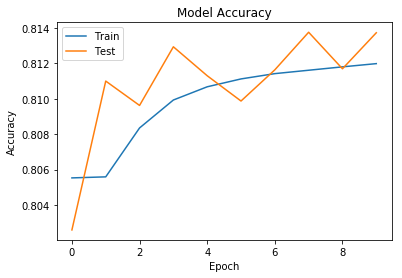

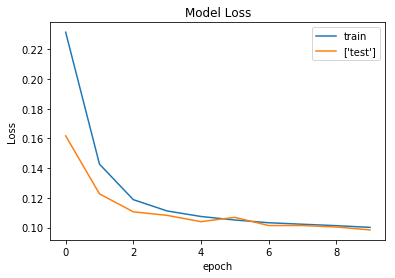

In [18]:
def main(epochs = 10, batch_size=128):
    data = DATA()
    ae = AE(data.input_shape)
    
    history = ae.fit(data.x_train, data.x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2)
    
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    
if __name__ == '__main__':
    main()